In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random
import torch.utils.data as Data
from torch.nn import init
from collections import OrderedDict
import pandas as pd
from d2l import torch as d2l

In [2]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] = figsize

def data_iter(batch_size, features, labels):
    #读取数据，每次返回batch_size大小得随机样本的特征和标签
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices) #样本读取顺序随机
    for i in range(0, num_examples, batch_size):
        #最后一次可能不足batch
        j = torch.LongTensor(indices[i:min(i+batch_size,num_examples)])
        yield features.index_select(0,j), labels.index_select(0,j)

def linreg(X, w, b):
    #定义模型，矩阵乘法
    return torch.mm(X, w) + b 

def squared_loss(y_hat, y):
    #定义损失函数， 返回的损失向量
    return (y_hat-y.view(y_hat.size()))**2 / 2

def sgd(params, lr, batch_size):
    #定义优化算法
    for param in params:
        param.data -= lr * param.grad / batch_size

def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]


def show_fashion_mnist(images, labels):
    #可以在一行里画出多张图像和对应标签的函数
    use_svg_display()
    # 这里的_表示我们忽略（不使用）的变量
    _, figs = plt.subplots(1, len(images), figsize=(12, 12))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img.view((28, 28)).numpy())
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

def load_data_fashion_mnist(batch_size, resize=None, root='~/Datasets/FashionMNIST'):
    """Download the fashion mnist dataset and then load into memory."""
    trans = []
    if resize:
        trans.append(torchvision.transforms.Resize(size=resize))
    trans.append(torchvision.transforms.ToTensor())

    transform = torchvision.transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root=root, train=True, download=True, transform=transform)
    mnist_test = torchvision.datasets.FashionMNIST(root=root, train=False, download=True, transform=transform)

    train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

    return train_iter, test_iter

def evaluate_accuracy(data_iter, net):
    #评价模型net再数据集data_iter上的准确率
    #后续加上dropout
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        if isinstance(net, torch.nn.Module):
            net.eval() #评估模式，会关闭dropout
            acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
            net.train() #改回训练模式
        else: #自定义模型
            if('is_training' in net.__code__.co_varnames):
                #如果又is_training这个参数
                acc_sum += (net(X, is_training=False).argmax(dim=1)==y).float().sum().item()
            else:
                acc_sum += (net(X).argmax(dim=1)==y).float().sum().item()
        n+= y.shape[0]
    return acc_sum / n

def train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size,
             params=None, lr=None, optimizer=None):
    
    #训练模型
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            #梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            if optimizer is None:
                sgd(params, lr, batch_size)
            else:
                optimizer.step()
            
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch %d, loss %.4f, train acc %.3f, test acc %.3f'
              % (epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))
        
#对x的形状转换,把图片拉成一个向量   
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
    def forward(self, x):
        return x.view(x.shape[0],-1)
    
#作图函数，对y轴使用了对数尺度
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    d2l.set_figsize(figsize)
    d2l.plt.xlabel(x_label)
    d2l.plt.ylabel(y_label)
    d2l.plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        d2l.plt.semilogy(x2_vals, y2_vals, linestyle=':')
        d2l.plt.legend(legend)

# 线性回归得从零开始实现

## 生成数据集
生成真实权重$ w = [2,-3.4]^T$ 偏差 $ b = 4.2$ 以及一个随机噪声

In [3]:
num_inputs = 2;
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.randn(num_examples, num_inputs, dtype=torch.float32) #1000行2列
labels = true_w[0] * features[:,0] + true_w[1] * features[:,1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()),
                       dtype=torch.float32)

In [4]:
print(features[0], labels[0])

tensor([-0.8499, -1.5756]) tensor(7.8779)


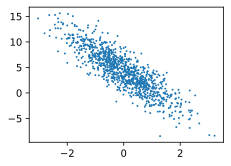

In [5]:
set_figsize()
plt.scatter(features[:, 1].numpy(), labels.numpy(), 1);

## 读取数据

In [6]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, y)
    break;

tensor([[-1.2821,  0.5874],
        [ 0.7806,  0.0694],
        [-0.6728,  0.1596],
        [-0.7519,  0.1223],
        [ 0.2393, -1.8010],
        [-1.2861, -0.4077],
        [ 0.2492, -0.2193],
        [ 0.0367, -3.0334],
        [-1.6213,  1.7835],
        [ 0.7016, -0.3041]]) tensor([-0.3677,  5.5403,  2.3332,  2.2804, 10.8030,  3.0207,  5.4429, 14.5928,
        -5.1243,  6.6456])


## 初始化模型参数

In [7]:
w = torch.tensor(np.random.normal(0, 0.01, (num_inputs, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

In [8]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

## 训练模型

In [9]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

#features和labels是之前随机生成的数据，w，b是之前初始化的模型参数
for epoch in range(num_epochs):
    #在每一个迭代周期中会使用所有的训练数据
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()
        l.backward()
        sgd([w,b],lr,batch_size)
        w.grad.data.zero_()
        b.grad.data.zero_()
    train_l = loss(net(features, w, b),labels)
    print('epoch %d, loss %f' %(epoch+1, train_l.mean().item()))

epoch 1, loss 0.028845
epoch 2, loss 0.000099
epoch 3, loss 0.000048


训练结束以后对比学会的参数和训练集的真是参数

In [10]:
print(true_w, '\n', w)
print(true_b, '\n', b)

[2, -3.4] 
 tensor([[ 1.9997],
        [-3.3999]], requires_grad=True)
4.2 
 tensor([4.1993], requires_grad=True)


# 线性回归简洁实现
使用pytorch的函数实现上一节内容

In [11]:
#生成数据不变
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
features = torch.tensor(np.random.normal(0, 1, (num_examples, num_inputs)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

## 读取数据
使用Pytorch提供的Data代替

In [12]:
batch_size = 10
dataset = Data.TensorDataset(features,labels)
data_iter = Data.DataLoader(dataset, batch_size, shuffle=True)

In [13]:
for X, y in data_iter:
    print(X, y)
    break;

tensor([[-0.6841, -0.4558],
        [ 1.4842,  0.1217],
        [-0.0491,  0.6237],
        [ 1.5210, -0.4347],
        [-1.0197,  0.7726],
        [ 0.1754,  0.6686],
        [ 0.0349,  0.6057],
        [ 1.2940, -2.0144],
        [-1.0444, -1.3335],
        [ 1.0158, -1.8535]]) tensor([ 4.3791,  6.7547,  1.9685,  8.7083, -0.4633,  2.2796,  2.2197, 13.6333,
         6.6519, 12.5157])


## 定义模型

In [14]:
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)
    
    def forward(self, x):
        y = self.linear(x)
        return y
net = LinearNet(num_inputs)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [15]:
#可以通过net.parameters()来查看模型所有的可学习参数，此函数将返回一个生成器。
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.6101,  0.0063]], requires_grad=True)
Parameter containing:
tensor([-0.3750], requires_grad=True)


## 初始化模型参数

In [16]:
init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0)

Parameter containing:
tensor([0.], requires_grad=True)

## 定义损失函数

In [17]:
loss = nn.MSELoss()

## 定义优化算法

In [18]:
optimizer = optim.SGD(net.parameters(),lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [19]:
#调整学习率，不固定成一个常数
for param_group in optimizer.param_groups:
    param_group['lr'] *= 0.1

## 训练模型

In [20]:
num_epochs = 3
for epoch in range(1, num_epochs+1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 6.208903
epoch 2, loss: 4.975375
epoch 3, loss: 0.614819


In [21]:
#比较学到的模型参数和真实的模型参数
dense = net.linear
print(true_w, dense.weight)
print(true_b, dense.bias)

[2, -3.4] Parameter containing:
tensor([[ 1.6489, -2.7951]], requires_grad=True)
4.2 Parameter containing:
tensor([3.4744], requires_grad=True)


# 图像分类数据集（Fashion-MNIST）

In [22]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import sys

## 获取数据集

In [23]:
mnist_train = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='~/Datasets/FashionMNIST', train=False, download=True, transform=transforms.ToTensor())

D:\Anaconda\envs\pytorch\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [24]:
print(type(mnist_train))
print(len(mnist_train), len(mnist_test))

torchvision.datasets.mnist.FashionMNIST
60000 10000


In [25]:
feature, label = mnist_train[0]
print(feature.shape, label)

torch.Size([1, 28, 28]) 9


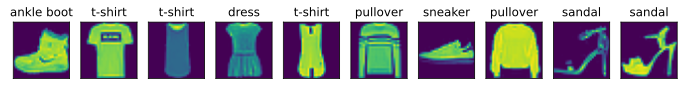

In [26]:
#展示数据
X, y = [], []
for i in range(10):
    X.append(mnist_train[i][0])
    y.append(mnist_train[i][1])
show_fashion_mnist(X, get_fashion_mnist_labels(y))

## 读取小批量
数据读取经常是训练的性能瓶颈，特别当模型较简单或者计算硬件性能较高时。
PyTorch的DataLoader中一个很方便的功能是允许使用多进程来加速数据读取。
这里通过参数num_workers来设置4个进程读取数据。

In [27]:
batch_size = 256
if sys.platform.startswith('win'):
    num_workers = 0  # 0表示不用额外的进程来加速读取数据
else:
    num_workers = 4
train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_iter = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=True, num_workers=num_workers)


In [28]:
start = time.time()
for X, y in train_iter:
    continue
print('%.2f sec' % (time.time() - start))


4.81 sec


# softmax回归的从零开始实现

In [29]:
import torch
import torchvision
import numpy as np
import sys


In [30]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

## 初始化模型参数

In [31]:
num_inputs = 784
num_outputs = 10
W = torch.tensor(np.random.normal(0,0.01,(num_inputs,num_outputs)), dtype=torch.float)
b = torch.zeros(num_outputs, dtype=torch.float)
W.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

## 实现softmax运算

In [32]:
#按维度操作介绍,需要完全理解其中的含义
X = torch.tensor([[1, 2, 3], [4, 5, 6]])
print(X.sum(dim=0, keepdim=True))
print(X.sum(dim=1, keepdim=True))

tensor([[5, 7, 9]])
tensor([[ 6],
        [15]])


In [33]:
#需要完全理解其中的含义，X维度为（样本数X分类个数）
def softmax(X):
    X_exp = X.exp() #X_exp维度不变, 计算e的元素数值次方
    partition = X_exp.sum(dim=1, keepdim=True) #对每一行，即每一个样本计算softmax分母的总数
    return X_exp / partition

In [34]:
X = torch.rand((2, 5))
X_prob = softmax(X)
print(X_prob, X_prob.sum(dim=1))

tensor([[0.1472, 0.2037, 0.1722, 0.2348, 0.2421],
        [0.1241, 0.3032, 0.2009, 0.2474, 0.1245]]) tensor([1., 1.])


## 定义模型


In [35]:
def net(X):
    return softmax(torch.mm(X.view((-1, num_inputs)), W)+b)

## 定义损失函数

In [36]:
y_hat = torch.tensor([[0.1, 0.3, 0.6],[0.3, 0.2, 0.5]])
y = torch.LongTensor([0, 2])
y_hat.gather(1, y.view(-1, 1))

tensor([[0.1000],
        [0.5000]])

In [37]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat.gather(1, y.view(-1, 1)))

## 计算分类准确率

In [38]:
def accuracy(y_hat, y):
    return (y_hat.argmax(dim=1) == y).float().mean().item()

In [39]:
#使用在演示gather函数时定义的变量y_hat和y，
#并将它们分别作为预测概率分布和标签。
#可以看到，第一个样本预测类别为2（该行最大元素0.6在本行的索引为2），与真实标签0不一致；
#第二个样本预测类别为2（该行最大元素0.5在本行的索引为2），与真实标签2一致。
#因此，这两个样本上的分类准确率为0.5
print(accuracy(y_hat, y))

0.5


In [40]:
#因为我们随机初始化了模型net，所以这个随机模型的准确率应该接近于类别个数10的倒数即0.1。
print(evaluate_accuracy(test_iter, net))

0.0835


## 训练模型

In [41]:
num_epochs, lr = 5, 0.1

train_ch3(net, train_iter, test_iter, cross_entropy,
         num_epochs, batch_size, [W,b], lr)

epoch 1, loss 0.7848, train acc 0.748, test acc 0.793
epoch 2, loss 0.5700, train acc 0.813, test acc 0.809
epoch 3, loss 0.5256, train acc 0.826, test acc 0.815
epoch 4, loss 0.5009, train acc 0.832, test acc 0.825
epoch 5, loss 0.4856, train acc 0.837, test acc 0.825


## 预测

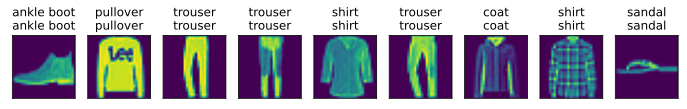

In [42]:
X, y = iter(test_iter).next()
true_labels = get_fashion_mnist_labels(y.numpy())
pred_labels = get_fashion_mnist_labels(net(X).argmax(dim=1).numpy())
titles = [true + '\n' + pred for true, pred in zip(true_labels, pred_labels)]
show_fashion_mnist(X[0:9], titles[0:9])

# softmax回归的简洁实现

## 获取和读取数据

In [43]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

## 定义和初始化模型

In [44]:
num_inputs = 28 * 28
num_outputs = 10
class LinearNet(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(num_inputs, num_outputs)
    
    def forward(self, x):
        y = self.linear(x.view(x.shape[0], -1))
        return y

net = LinearNet(num_inputs, num_outputs)

In [45]:
init.normal_(net.linear.weight, mean=0, std=0.01)
init.constant_(net.linear.bias, val=0)

Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)

## softmax和交叉熵损失函数

In [46]:
loss = nn.CrossEntropyLoss()

## 定义优化算法

In [47]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.1)

## 训练模型

In [48]:
num_epochs = 5
train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0031, train acc 0.751, test acc 0.782
epoch 2, loss 0.0022, train acc 0.812, test acc 0.800
epoch 3, loss 0.0021, train acc 0.827, test acc 0.805
epoch 4, loss 0.0020, train acc 0.833, test acc 0.810
epoch 5, loss 0.0019, train acc 0.837, test acc 0.823


# 多层感知机从零开始实现

In [49]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

## 定义模型参数

In [50]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256
W1 = torch.tensor(np.random.normal(0,0.01, (num_inputs, num_hiddens)), dtype=torch.float)
b1 = torch.zeros(num_hiddens, dtype=torch.float)
W2 = torch.tensor(np.random.normal(0,0.01, (num_hiddens, num_outputs)),dtype=torch.float)
b2 = torch.zeros(num_outputs, dtype=torch.float)

params = [W1, b1, W2, b2]
for param in params:
    param.requires_grad_(requires_grad=True)

## 定义激活函数

In [51]:
def relu(X):
    return torch.max(input=X, other=torch.tensor(0.0))

## 定义模型

In [52]:
def net(X):
    X = X.view((-1, num_inputs))
    H = relu(torch.matmul(X, W1) + b1)
    return torch.matmul(H, W2) + b2

## 定义损失函数

In [53]:
loss = torch.nn.CrossEntropyLoss()

## 训练模型

In [54]:
num_epochs, lr = 5, 100.0
train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)

epoch 1, loss 0.0031, train acc 0.709, test acc 0.793
epoch 2, loss 0.0019, train acc 0.822, test acc 0.812
epoch 3, loss 0.0017, train acc 0.844, test acc 0.823
epoch 4, loss 0.0015, train acc 0.855, test acc 0.847
epoch 5, loss 0.0015, train acc 0.864, test acc 0.846


# 多层感知机的简洁实现

## 定义模型
和softmax回归唯一的不同在于，我们多加了一个全连接层作为隐藏层。它的隐藏单元个数为256，并使用ReLU函数作为激活函数。

In [55]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

net = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs), 
)

for params in net.parameters():
    init.normal_(params, mean=0, std=0.01)


## 读取数据并训练模型

In [56]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.5)
num_epochs = 5
train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0032, train acc 0.696, test acc 0.771
epoch 2, loss 0.0019, train acc 0.818, test acc 0.827
epoch 3, loss 0.0017, train acc 0.839, test acc 0.839
epoch 4, loss 0.0016, train acc 0.852, test acc 0.812
epoch 5, loss 0.0015, train acc 0.863, test acc 0.822


# 模型选择，欠拟合，过拟合

## 多项式函数拟合实验
我们将生成一个人工数据集。在训练数据集和测试数据集中，给定样本特征xx，我们使用如下的三阶多项式函数来生成该样本的标签：
$ y=1.2x−3.4x^2+5.6x^3+5+ϵ $
其中噪声项ϵϵ服从均值为0、标准差为0.01的正态分布。训练数据集和测试数据集的样本数都设为100。

In [57]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1) 
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1]
          + true_w[2] * poly_features[:, 2] + true_b)
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [58]:
features[:2], poly_features[:2], labels[:2]

(tensor([[ 0.7236],
         [-0.7312]]),
 tensor([[ 0.7236,  0.5236,  0.3788],
         [-0.7312,  0.5347, -0.3910]]),
 tensor([6.2132, 0.1226]))

## 定义，训练和测试模型
多项式函数拟合也使用平方损失函数。因为我们将尝试使用不同复杂度的模型来拟合生成的数据集，所以把模型定义部分放在fit_and_plot函数中

In [59]:
num_epochs, loss = 100, torch.nn.MSELoss()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = torch.nn.Linear(train_features.shape[-1], 1)
    # 通过Linear文档可知，pytorch已经将参数初始化了，所以我们这里就不手动初始化了

    batch_size = min(10, train_labels.shape[0])    
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y.view(-1, 1))
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())
        test_ls.append(loss(net(test_features), test_labels).item())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data,
          '\nbias:', net.bias.data)


## 三阶多项式的函数拟合(正常)

final epoch: train loss 0.00013946906256023794 test loss 0.00013485678937286139
weight: tensor([[ 1.2136, -3.3995,  5.5959]]) 
bias: tensor([5.0006])


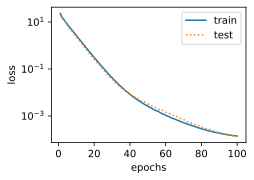

In [60]:
fit_and_plot(poly_features[:n_train,:], poly_features[n_train:,:],
            labels[:n_train],labels[n_train:])

## 线性函数拟合(欠拟合)

final epoch: train loss 62.793758392333984 test loss 94.01859283447266
weight: tensor([[14.2682]]) 
bias: tensor([3.0684])


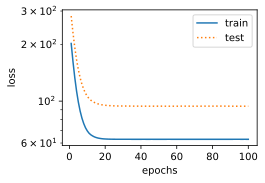

In [61]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:])

## 训练样本不足（过拟合）

final epoch: train loss 0.7091412544250488 test loss 101.24256896972656
weight: tensor([[2.0966, 0.6354, 1.8489]]) 
bias: tensor([2.6284])


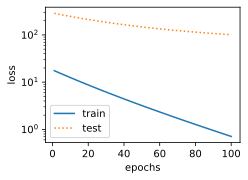

In [62]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
             labels[n_train:])

# 权重衰减（解决过拟合问题）

## 高维线性回归实验
下面，我们以高维线性回归为例来引入一个过拟合问题，并使用权重衰减来应对过拟合。设数据样本特征的维度为pp。对于训练数据集和测试数据集中特征为$ x_1, x_2, ..., x_p$的任一样本，我们使用如下的线性函数来生成该样本的标签：
$ y = 0.05+\sum_{i=1}^p0.01x_i+\epsilon$

In [63]:
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05

features = torch.randn((n_train + n_test, num_inputs))
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

## 从零开始实现

### 初始化模型参数

In [64]:
def init_params():
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### 定义$ L_2$范数惩罚项

In [65]:
def l2_penalty(w):
    return (w**2).sum() / 2

### 定义训练和测试

In [66]:
batch_size, num_epochs, lr = 1, 100, 0.003
net, loss = linreg, squared_loss
dataset = torch.utils.data.TensorDataset(train_features,train_labels)
train_iter = torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)

In [67]:
def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            #添加L2惩罚想
            l = loss(net(X,w,b), y) + lambd * l2_penalty(w)
            l = l.sum()
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            sgd([w,b], lr, batch_size)
        train_ls.append(loss(net(train_features, w, b),train_labels).mean().item())
        test_ls.append(loss(net(test_features, w, b),test_labels).mean().item())
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())

L2 norm of w: 12.536528587341309


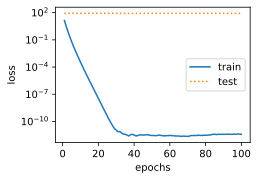

In [68]:
#不使用权重衰减
fit_and_plot(lambd=0)

L2 norm of w: 0.04524252936244011


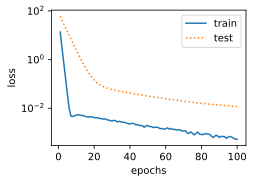

In [69]:
#使用权重衰减
fit_and_plot(lambd=3)

## 简洁实现

In [70]:
def fit_and_plot_pytorch(wd):
    net = nn.Linear(num_inputs, 1)
    nn.init.normal_(net.weight, mean=0, std=1)
    nn.init.normal_(net.bias, mean=0, std=1)
    optimizer_w = torch.optim.SGD(params=[net.weight],lr=lr,weight_decay=wd)
    optimizer_b = torch.optim.SGD(params=[net.bias],lr=lr)
    
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X), y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            l.backward()
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features),train_labels).mean().item())
        test_ls.append(loss(net(test_features),test_labels).mean().item())
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
                 range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())

L2 norm of w: 3.9443442821502686


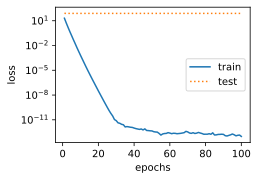

In [71]:
fit_and_plot_pytorch(0)

L2 norm of w: 3.9443442821502686


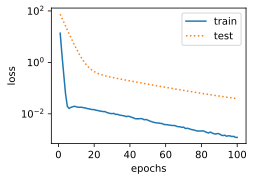

In [72]:
fit_and_plot_pytorch(3)

# 丢弃法（解决过拟合问题）

## 从零开始实现

In [73]:
def dropout(X, drop_prob):
    X = X.float()
    assert 0 <= drop_prob <= 1
    keep_prob = 1 - drop_prob
    if keep_prob == 0:
        return torch.zeros_like(X)
    mask = (torch.rand(X.shape)< keep_prob).float()
    
    return mask * X / keep_prob

In [74]:
#测试dropout
X = torch.arange(16).view(2, 8)
dropout(X, 0)

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])

In [75]:
dropout(X, 0.5)

tensor([[ 0.,  2.,  0.,  6.,  8., 10., 12.,  0.],
        [ 0.,  0.,  0.,  0., 24.,  0.,  0.,  0.]])

In [76]:
dropout(X, 1)

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

### 定义模型参数

In [77]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

W1 = torch.tensor(np.random.normal(0, 0.01, size=(num_inputs, num_hiddens1)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens1, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens1, num_hiddens2)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens2, requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens2, num_outputs)), dtype=torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs, requires_grad=True)

params = [W1, b1, W2, b2, W3, b3]

### 定义模型

In [78]:
drop_prob1, drop_prob2 = 0.2, 0.5

def net(X, is_training=True):
    X = X.view(-1, num_inputs)
    H1 = (torch.matmul(X, W1)+b1).relu()
    if is_training:
        H1 = dropout(H1, drop_prob1)
    H2 = (torch.matmul(H1,W2)+b2).relu()
    if is_training:
        H2 = dropout(H2, drop_prob2)
    return torch.matmul(H2, W3)+b3

In [79]:
num_epochs, lr, batch_size = 5, 100.0, 256
loss = torch.nn.CrossEntropyLoss()
train_iter, test_iter = load_data_fashion_mnist(batch_size)
train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr)


epoch 1, loss 0.0046, train acc 0.540, test acc 0.754
epoch 2, loss 0.0023, train acc 0.782, test acc 0.813
epoch 3, loss 0.0019, train acc 0.822, test acc 0.783
epoch 4, loss 0.0018, train acc 0.836, test acc 0.833
epoch 5, loss 0.0016, train acc 0.848, test acc 0.828


## 简洁实现

In [80]:
net = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens1),
    nn.ReLU(),
    nn.Dropout(drop_prob1),
    nn.Linear(num_hiddens1, num_hiddens2),
    nn.ReLU(),
    nn.Dropout(drop_prob2),
    nn.Linear(num_hiddens2, 10)
)

for param in net.parameters():
    nn.init.normal_(param, mean=0, std=0.01)

In [81]:
#训练并测试
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0048, train acc 0.526, test acc 0.725
epoch 2, loss 0.0023, train acc 0.780, test acc 0.775
epoch 3, loss 0.0020, train acc 0.816, test acc 0.811
epoch 4, loss 0.0018, train acc 0.835, test acc 0.802
epoch 5, loss 0.0017, train acc 0.846, test acc 0.843


# 实战预测房价

## 获取和读取数据集

In [82]:
train_data = pd.read_csv("./data/kaggle_house/train.csv")
test_data = pd.read_csv("./data/kaggle_house/test.csv")

In [83]:
#训练数据集包括1460个样本、80个特征和1个标签。
train_data.shape

(1460, 81)

In [84]:
test_data.shape

(1459, 80)

In [85]:
#查看前4个样本的前4个特征、后2个特征和标签
train_data.iloc[0:4, [0,1,2,3,-3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [86]:
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))

## 预处理数据
对连续数值的特征做标准化。对于缺失的特征值，我们将其替换成该特征的均值

In [87]:
numeric_features = all_features.dtypes[all_features.dtypes !='object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x : (x-x.mean())/(x.std()))
#正态分布标准化后平均值就是0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [88]:
#离散数值转换成指示特征
#dummy_na=True将缺失值也当作合法的特征值并专拣芝士特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [89]:
#最后，通过values属性得到NumPy格式的数据，并转成Tensor方便后面的训练。
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values, dtype=torch.float).view(-1, 1)

## 训练模型

In [90]:
loss = torch.nn.MSELoss()

def get_net(feature_num):
    net = nn.Linear(feature_num, 1)
    for param in net.parameters():
        nn.init.normal_(param, mean=0, std=0.01)
    return net

In [91]:
#下面定义比赛用来评价模型的对数均方根误差
def log_rmse(net, features, labels):
    with torch.no_grad():
        clipped_preds = torch.max(net(features), torch.tensor(1.0))
        rmse = torch.sqrt(loss(clipped_preds.log(), labels.log()))
    return rmse.item()

In [92]:
def train(net, train_features, train_labels, test_features, test_labels,
         num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
    #这里使用了Adam优化算法
    optimizer = torch.optim.Adam(params=net.parameters(),lr=learning_rate, weight_decay=weight_decay)
    net = net.float()
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X.float()), y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features, test_labels))
    return train_ls, test_ls

## K折交叉验证

In [93]:
def get_k_fold_data(k, i, X, y):
    #返回第i折交叉验证所需要的训练和验证数据
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j+1)*fold_size)
        X_part, y_part = X[idx,:], y[idx]
        if j == i:
            X_valid, y_valid = X_part,  y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat((X_train, X_part), dim=0)
            y_train = torch.cat((y_train, y_part), dim=0)
    return X_train, y_train, X_valid, y_valid

In [94]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate,
          weight_decay, batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k,i,X_train, y_train)
        net = get_net(X_train.shape[1]) #特征值数量
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                  weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == k-1:
            semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f' % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

fold 0, train rmse 0.170303, valid rmse 0.156751
fold 1, train rmse 0.162085, valid rmse 0.189482
fold 2, train rmse 0.163738, valid rmse 0.168354
fold 3, train rmse 0.167943, valid rmse 0.154816
fold 4, train rmse 0.162843, valid rmse 0.182901
5-fold validation: avg train rmse 0.165382, avg valid rmse 0.170461


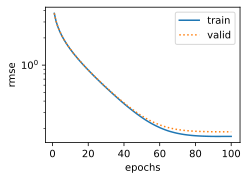

In [95]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

## 预测并在Kaggle提交结果

In [96]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                  num_epochs, lr, weight_decay, batch_size):
    net = get_net(train_features.shape[1])
    train_ls, _ = train(net, train_features, train_labels, None, None,
                       num_epochs, lr, weight_decay, batch_size)
    semilogy(range(1,num_epochs+1), train_ls, 'epochs','rmse')
    print('train rmse %f' % train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
    #在一行拼接起来
    submisstion = pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
    submisstion.to_csv('./submission.csv', index=False)

train rmse 0.162604


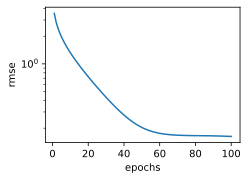

In [97]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)